https://github.com/gretelai/gretel-synthetics/blob/master/examples/timeseries_dgan.ipynb

In [16]:
# version recommended by source
!pip install torch==1.11.0

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
!pip install git+https://github.com/gretelai/gretel-synthetics.git

  Cloning https://github.com/gretelai/gretel-synthetics.git to /tmp/pip-req-build-4kpiphib
  Running command git clone --filter=blob:none -q https://github.com/gretelai/gretel-synthetics.git /tmp/pip-req-build-4kpiphib
  Resolved https://github.com/gretelai/gretel-synthetics.git to commit 2ed9d31ce8f56afd1519c38859ab081e8cdef579
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [4]:
# https://www.kaggle.com/code/xiaxiaxu/predictmachinefailureinadvance/data
sensor = pd.read_csv('sensor.csv') 

# data columns
COLS = ['sensor_25', 'sensor_11', 'sensor_36', 'sensor_34', 'machine_status']

# only keeping cols w high var in pca analysis + machine status
data = sensor[['timestamp'] + COLS]
data

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
0,2018-04-01 00:00:00,741.7151,47.52422,195.0655,171.9375,NORMAL
1,2018-04-01 00:01:00,741.7151,47.52422,195.0655,171.9375,NORMAL
2,2018-04-01 00:02:00,740.8031,48.17723,200.9694,169.9820,NORMAL
3,2018-04-01 00:03:00,739.2722,48.65607,193.1689,166.4987,NORMAL
4,2018-04-01 00:04:00,737.6033,49.06298,193.8770,164.7498,NORMAL
...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,700.5885,54.16052,817.5707,266.0334,NORMAL
220316,2018-08-31 23:56:00,698.4915,54.52602,807.0151,262.2222,NORMAL
220317,2018-08-31 23:57:00,703.1645,55.11779,805.5605,260.8372,NORMAL
220318,2018-08-31 23:58:00,697.3713,55.99321,807.0808,261.3184,NORMAL


In [5]:
# lets convert our datatypes to the correct ones

print(data.dtypes, '\n')
# i have no idea why i have to run this line twice for it to work.
data['timestamp']= pd.to_datetime(data['timestamp'])


timestamp          object
sensor_25         float64
sensor_11         float64
sensor_36         float64
sensor_34         float64
machine_status     object
dtype: object 



/tmp/ipykernel_2267/3253553817.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp']= pd.to_datetime(data['timestamp'])


In [6]:
# okay, what can our machine status be?

# data = data.convert_dtypes()
print(data.dtypes, '\n')
# i have no idea why i have to run this line twice for it to work.
data['timestamp']= pd.to_datetime(data['timestamp'])

data.machine_status.unique()

timestamp         datetime64[ns]
sensor_25                float64
sensor_11                float64
sensor_36                float64
sensor_34                float64
machine_status            object
dtype: object 



/tmp/ipykernel_2267/2577753386.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp']= pd.to_datetime(data['timestamp'])


array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

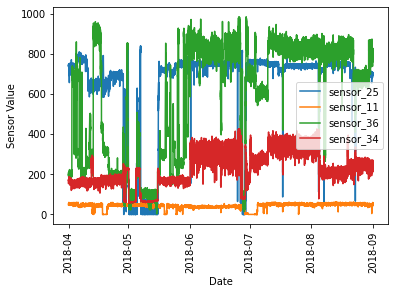

In [7]:
# Plot the 4 sensors 

for c in COLS:
    if c == 'machine_status':
        continue
    plt.plot(data["timestamp"], data[c], label=c)
    
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Sensor Value")
plt.xlabel("Date")
plt.show()

In [8]:
# how many NaN rows do we have?

print(len(data[data.isna().any(axis=1)]))

44


In [9]:
# lets drop them : ) 

data.dropna(axis=0, inplace=True)

print(len(data[data.isna().any(axis=1)]))

0


/tmp/ipykernel_2267/532009668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(axis=0, inplace=True)


In [10]:
# lets try only using data centered around 2 failures.

data_around_failures = data.iloc[16000:26080]
print(len(data_around_failures))
data_around_failures

10080


,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
16000,2018-04-12 02:40:00,649.0801,49.93274,299.4172,160.6844,NORMAL
16001,2018-04-12 02:41:00,651.8054,51.08754,296.3760,162.5435,NORMAL
16002,2018-04-12 02:42:00,650.1391,51.24662,305.7853,164.4021,NORMAL
16003,2018-04-12 02:43:00,649.2632,51.93151,294.0909,166.5538,NORMAL
16004,2018-04-12 02:44:00,643.1567,51.71158,298.7494,168.0882,NORMAL
...,...,...,...,...,...,...
26076,2018-04-19 02:36:00,650.5313,0.00000,299.8132,177.0259,RECOVERING
26077,2018-04-19 02:37:00,648.3717,0.00000,300.4203,178.1746,RECOVERING
26078,2018-04-19 02:38:00,648.1866,0.00000,298.3055,179.5653,RECOVERING
26079,2018-04-19 02:39:00,650.0446,0.00000,297.7022,181.8661,RECOVERING


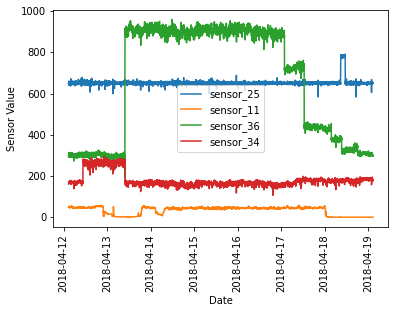

In [11]:
# Plot the 4 sensors 

for c in COLS:
    if c == 'machine_status':
        continue
    plt.plot(data_around_failures["timestamp"],
             data_around_failures[c], label=c)
    
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Sensor Value")
plt.xlabel("Date")
plt.show()

In [12]:
# let's now scale our data between 0-1

scaler = MinMaxScaler((0,1))
sensor_cols = ['sensor_25', 'sensor_11', 'sensor_36', 'sensor_34']

# scaling our data, then saving our scaler object for future use.
data_around_failures[sensor_cols] = scaler.fit_transform(data_around_failures[sensor_cols])

dump(scaler, open('dGAN_scaler.pkl', 'wb'))

/tmp/ipykernel_2267/2643193233.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_around_failures[sensor_cols] = scaler.fit_transform(data_around_failures[sensor_cols])
/opt/app-root/lib64/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


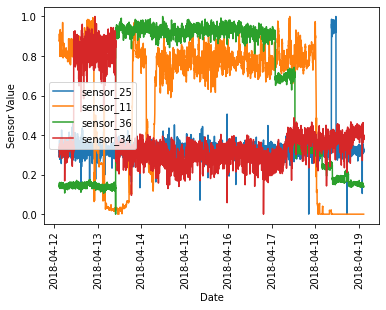

In [13]:
# Plot the 4 scaled sensors 

for c in COLS:
    if c == 'machine_status':
        continue
    plt.plot(data_around_failures["timestamp"],
             data_around_failures[c], label=c)
    
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Sensor Value")
plt.xlabel("Date")
plt.show()

In [14]:
# sanity check - let's unscale the data and replot 

sc = load(open('dGAN_scaler.pkl', 'rb'))

unscaled_data = sc.inverse_transform(data_around_failures[sensor_cols])

unscaled_data_df = pd.DataFrame(unscaled_data, columns=sensor_cols)
unscaled_data_df

,sensor_25,sensor_11,sensor_36,sensor_34
0,649.0801,49.93274,299.4172,160.6844
1,651.8054,51.08754,296.3760,162.5435
2,650.1391,51.24662,305.7853,164.4021
3,649.2632,51.93151,294.0909,166.5538
4,643.1567,51.71158,298.7494,168.0882
...,...,...,...,...
10075,650.5313,0.00000,299.8132,177.0259
10076,648.3717,0.00000,300.4203,178.1746
10077,648.1866,0.00000,298.3055,179.5653
10078,650.0446,0.00000,297.7022,181.8661


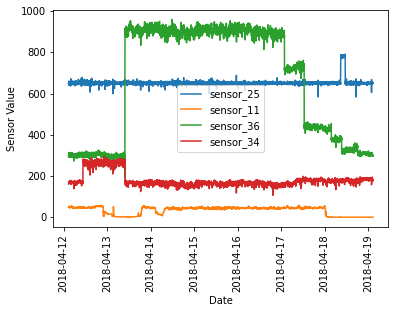

In [15]:
for c in COLS:
    if c == 'machine_status':
        continue
    plt.plot(data_around_failures["timestamp"],
             unscaled_data_df[c], label=c)
    
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Sensor Value")
plt.xlabel("Date")
plt.show()

okay, scaling sanity check passed. lets start splitting the data to prepare it for training in dGAN.

NOTE: data generated will be in the shape of data passed in for training. so if we pass in samples of 10 rows per, it will only generate a sample of 10 rows.

we have 10,080 rows of data now, which corresponds to 10,080 minutes of data = 168 hours of data = 7 days of data.

I'm going to try splitting the data into two hour segments - giving us 84 120row/minute readings.

In [29]:
# dropping timestamp col
features = data_around_failures.drop(columns=["timestamp","machine_status"]).to_numpy()
print(features.shape)

# number of samples to split into
n = features.shape[0] // 120
print(n)

# reshape the data accordingly
features = features[:(n*120),:].reshape(-1, 120, features.shape[1])
# Shape is now (# examples, # time points, # features)
print(features.shape)

(10080, 4)
84
(84, 120, 4)


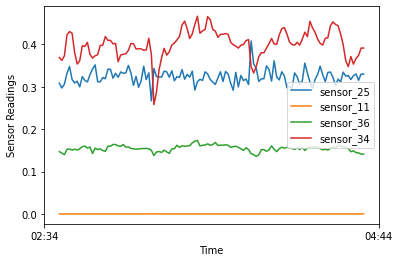

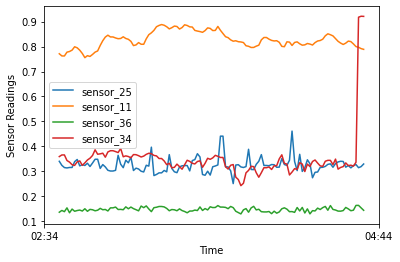

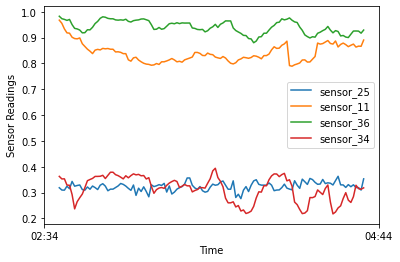

In [30]:
# Show a few of the 2-hour training samples
# note x-axis isnt accurate in these plots.
xaxis_2hr = data_around_failures["timestamp"][0:120]

def plot_hours(f):
    for i, c in enumerate(sensor_cols):
        plt.plot(xaxis_2hr, f[:,i], label=c)
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(2,24,3)))
    ax.xaxis.set_major_formatter(md.DateFormatter("%H:%M"))
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Sensor Readings")
    plt.show()

plot_hours(features[80,:,:])
plot_hours(features[3,:,:])
plot_hours(features[21,:,:])

In [31]:
# Recommended to train with a GPU - am not for now.
torch.cuda.is_available()

False

In [33]:
# set up DGAN config.

config = DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=12,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=False, # already scaled
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000)

model = DGAN(config)

In [34]:
model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)

2022-07-12 15:56:17,243 : MainThread : INFO : epoch: 0
/opt/app-root/lib64/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
2022-07-12 15:56:17,559 : MainThread : INFO : epoch: 1
2022-07-12 15:56:17,717 : MainThread : INFO : epoch: 2
2022-07-12 15:56:17,789 : MainThread : INFO : epoch: 3
2022-07-12 15:56:17,907 : MainThread : INFO : epoch: 4
2022-07-12 15:56:17,955 : MainThread : INFO : epoch: 5
2022-07-12 15:56:18,005 : MainThread : INFO : epoch: 6
2022-07-12 15:56:18,047 : MainThread : INFO : epoch: 7
2022-07-12 15:56:18,090 : MainThread : INFO : epoch: 8
2022-07-12 15:56:18,137 : MainThread : INFO : epoch: 9
2022-07-12 15:56:18,178 : MainThread : INFO : epoch: 10
2022-07-12 15:56:18,227 : MainThread : INFO : epoch: 11
2022-07-12 15:56:18,269 : MainThread : INFO : epoch: 12
2022-07-12 15:56:18,318 : Ma

finished training at around 6-7 mins on large notebook image - not bad! 

In [36]:
# Generate synthetic data - this ran near instantly
_, synthetic_features = model.generate_numpy(100)

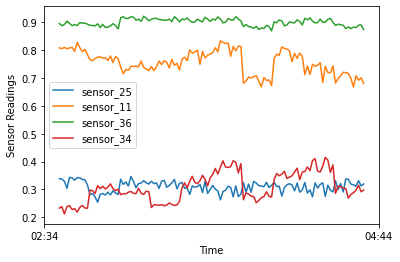

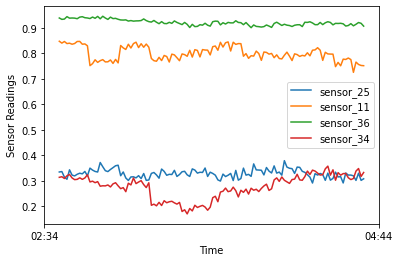

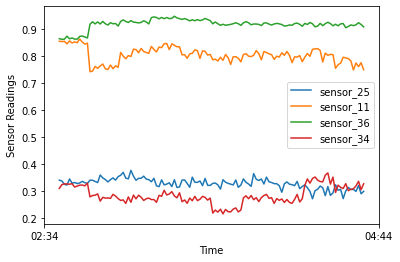

In [38]:
# Show some synthetic 2-hour samples
plot_hours(synthetic_features[10,:,:])
plot_hours(synthetic_features[42,:,:])
plot_hours(synthetic_features[6,:,:])

In [41]:
# Compare (non-temporal) correlations between the 4 sensors
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=sensor_cols)

print("Correlation in real data:")
print(data_around_failures.drop(columns=["timestamp","machine_status"]).corr())
print()
print("Correlation in synthetic data:")
print(synthetic_df.corr())

# Correlations between sensor variables are similar

Correlation in real data:
           sensor_25  sensor_11  sensor_36  sensor_34
sensor_25   1.000000  -0.197810  -0.145523  -0.022030
sensor_11  -0.197810   1.000000   0.402658  -0.180775
sensor_36  -0.145523   0.402658   1.000000  -0.632188
sensor_34  -0.022030  -0.180775  -0.632188   1.000000

Correlation in synthetic data:
           sensor_25  sensor_11  sensor_36  sensor_34
sensor_25   1.000000  -0.009308  -0.036538   0.010762
sensor_11  -0.009308   1.000000   0.493117  -0.232275
sensor_36  -0.036538   0.493117   1.000000  -0.622317
sensor_34   0.010762  -0.232275  -0.622317   1.000000


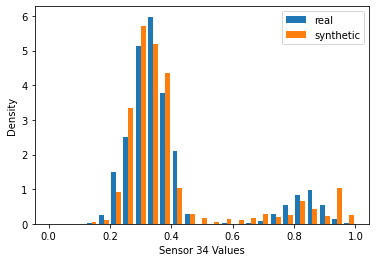

In [43]:
# Compare distribution of sensor_34 values
plt.hist([features[:,:,3].flatten(), synthetic_features[:,:,3].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 34 Values")
plt.ylabel("Density")
plt.show()

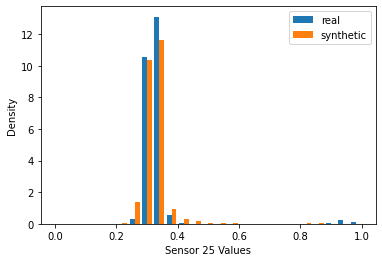

In [45]:
# Compare distribution of sensor_25 values
plt.hist([features[:,:,0].flatten(), synthetic_features[:,:,0].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 25 Values")
plt.ylabel("Density")
plt.show()

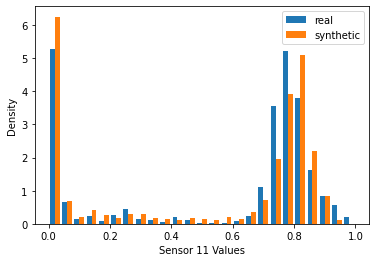

In [47]:
# Compare distribution of sensor_11 values
plt.hist([features[:,:,1].flatten(), synthetic_features[:,:,1].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 11 Values")
plt.ylabel("Density")
plt.show()

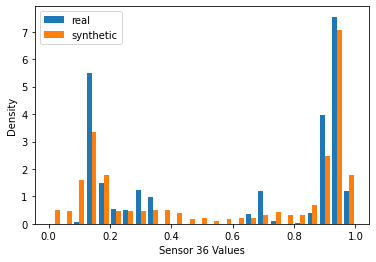

In [49]:
# Compare distribution of sensor_36 values
plt.hist([features[:,:,2].flatten(), synthetic_features[:,:,2].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 36 Values")
plt.ylabel("Density")
plt.show()

In [53]:
# saving model for future use 
model.save("dgan_model_0.pt")

# X = model.load("dgan_model_0.pt")

# X


### NOTES ON RESULTS

- this is really promising!! train time was fast, data generation is near instantaneous and overall the synthetic data looks solid to the eye test and simple metrics and plots.

- in future attempts, I'll be passing in more data to the model, likely will be using longer samples and more of them, either by selecting a larger initial slice of the data, or by using overlapping windows, or both! We'll see how that affects train time and performance. 

- will need to discuss with team how long the samples generated should be ideally. if using longer samples (like days of data) is needed, we could try thinning the data out again and using every 2 or 3 rows if needed.

- also, I scaled the data manually before but it looks like we could pass in the data without scaling and then it would scale the data for training and then unscale the data when generating synthetic data - could be convenient if it works well. 

- could also try passing in 'machine_status' and seeing how that changes results as well.